In [1]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%matplotlib notebook

In [32]:
class DiffMatrix():
    
    def __init__(self,
                size= 300,
                diffusion_characteristics = 'default',
                start_template = 'square'):
#       Reaction caracteristics
        if diffusion_characteristics == 'default':
            self.diff_a = 1
            self.diff_b = 0.5
            self.feed_rate = 0.055
            self.kill_rate = 0.062
            self.timestep = 1
            self.laplace_window = 3
        
        self.start_template = start_template
        self.size = size
        self.matrix_shape = (int(self.size), int(self.size))
        self.matrix_a = self.initiate_matrix()
        self.matrix_b = self.initiate_matrix()
        self.matrix_a_new = self.initiate_matrix()
        self.matrix_b_new = self.initiate_matrix()
    
    def initiate_matrix(self):
        matrix = np.zeros(self.matrix_shape)
        return matrix
    
    def fill_matrix_tiny(self):
        for matrix in (self.matrix_a, self.matrix_b):
            matrix[1][2] = 0.3
            matrix[1][3] = 0.3
            matrix[2][2] = 0.3

    def fill_matrix_random(self):
        self.matrix_a = np.random.rand(*self.matrix_shape)
        self.matrix_b = np.random.rand(*self.matrix_shape)
        
    def fill_matrix_propper(self):
        self.matrix_a = np.ones(self.matrix_shape)
        self.matrix_b = np.zeros(self.matrix_shape)
        
        if self.start_template == 'line':
            start_b = int(0.4 * self.size)
            end_b = int(0.6 * self.size)
            self.matrix_b[start_b:end_b] = 1
        
        elif self.start_template == 'square':
            start_b = int(0.45 * self.size)
            end_b = int(0.55 * self.size)
            self.matrix_b[start_b:end_b, start_b:end_b] = 1
    
    def switch_new(self):
        self.matrix_a = self.matrix_a_new.copy()
        self.matrix_b = self.matrix_b_new.copy()
    
    def feed(self):
        # create a up until 1
        self.matrix_a_new += self.feed_rate * (1 - self.matrix_a)
        #bestroy b if any
        self.matrix_b_new -= (self.feed_rate + self.kill_rate) * self.matrix_b
    
    def react(self):
        #consume a and turn it into b
        reaction_rate = self.matrix_a * self.matrix_b * self.matrix_b
        
        self.matrix_a_new -= reaction_rate
        self.matrix_b_new += reaction_rate    
        
    def diffuse(self):
        self.matrix_a_new = ndimage.generic_filter(dm.matrix_a, self.quickest_lap_filter, size=(3,3))
        self.matrix_b_new = ndimage.generic_filter(dm.matrix_b, self.quickest_lap_filter, size=(3,3))
    
    def lap_filter(self,x):
        x = x.reshape((self.laplace_window,self.laplace_window))
        filter_total = x[1][1] * -1
        # cross:
        filter_total += x[1][0] * 0.2
        filter_total += x[0][1] * 0.2
        filter_total += x[1][2] * 0.2
        filter_total += x[2][1] * 0.2

        #diag
        filter_total += x[0][0] * 0.05
        filter_total += x[2][0] * 0.05
        filter_total += x[0][2] * 0.05
        filter_total += x[2][2] * 0.05
        return filter_total

    @staticmethod
    def quick_lap_filter(x):
        diag = 0.05
        cross = 0.2
        middle = -1
        score_arr = np.array([diag,cross,diag,
                    cross,middle,cross,
                    diag,cross,diag])

        return sum(x * score_arr)
    
    @staticmethod
    def quickest_lap_filter(x):
        diag = 0.05
        cross = 0.2
        middle = -1

        score = x[4] * middle
        score += (x[1] + x[3] + x[5] + x[7]) * cross 
        score += (x[0] + x[2] + x[6] + x[8]) * diag
        return score
        
    @staticmethod
    def lap_filter_roll(x):

        rolled_x = np.roll(matrix,x,axis=0)
        for y in y_coord:
            multi = self.find_multiplier(x,y)
            rolled_y = np.roll(rolled_x,y,axis=1)
            matrix_new += (multi * rolled_y)
    
    def _next(self):
        print(f"{self.matrix_a_new}")
        print(f"{self.matrix_b_new}")
        self.diffuse()
        print('diff')
        print(f"{self.matrix_a_new}")
        print(f"{self.matrix_b_new}")

#         print(f"{self.matrix_a_new.mean()}, {self.matrix_a_new.max()}")
#         print(f"{self.matrix_b_new.mean()}, {self.matrix_b_new.max()}")
        self.feed()
        print('feed')
        print(f"{self.matrix_a_new}")
        print(f"{self.matrix_b_new}")
#         print(f"{self.matrix_a_new.mean()}, {self.matrix_a_new.max()}")
#         print(f"{self.matrix_b_new.mean()}, {self.matrix_b_new.max()}")
        self.react()
        print('react')
        print(f"{self.matrix_a_new}")
        print(f"{self.matrix_b_new}")
#         print(f"{self.matrix_a_new.mean()}, {self.matrix_a_new.max()}")
#         print(f"{self.matrix_b_new.mean()}, {self.matrix_b_new.max()}")
        
        
        self.matrix_a_new += self.matrix_a
        self.matrix_b_new += self.matrix_b
           
        self.switch_new()

#         self.matrix_a_new = self.initiate_matrix()
#         self.matrix_b_new = self.initiate_matrix()
#         print(f"{self.matrix_a_new.mean()}, {self.matrix_a_new.max()}")
#         print(f"{self.matrix_b_new.mean()}, {self.matrix_b_new.max()}")


In [4]:
def plthm(dm,i):
    axes[0].imshow(dm.matrix_a, cmap='binary', interpolation='nearest',vmin=0, vmax=1)
    axes[0].set_title(f'Activator at {i}')
    axes[1].set_title(f'Blocker at {i}')
    axes[1].imshow(dm.matrix_b, cmap='binary', interpolation='nearest',vmin=0, vmax=1)
    plt.show()
    fig.canvas.draw()

In [5]:
dm = DiffMatrix(100,start_template='square')
dm.fill_matrix_propper()

In [6]:
plthm(dm,1)

NameError: name 'axes' is not defined

<IPython.core.display.Javascript object>


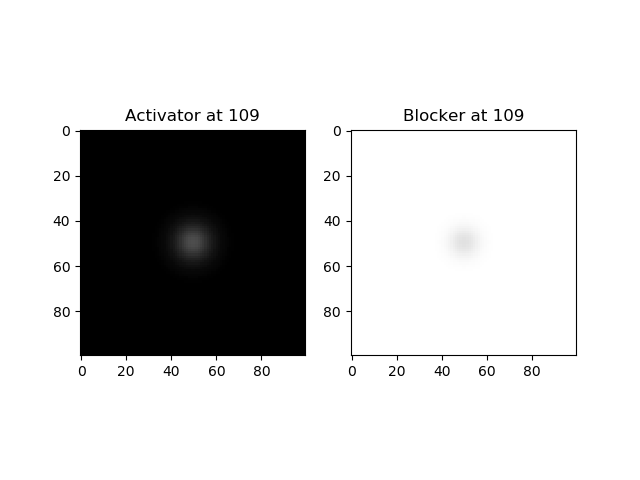

  1%|          | 1/110 [00:00<00:24,  4.38it/s]

0
Mean a: 0.99Mean b:0.01883
Max a: 1.0Max b:1.883


  2%|▏         | 2/110 [00:00<00:23,  4.62it/s]

1
Mean a: 0.9902110000000001Mean b:0.01696589
Max a: 1.0Max b:1.6626890000000003
2
Mean a: 0.9873992529129199Mean b:0.018331022957080136
Max a: 1.0Max b:1.6202037960896556


  4%|▎         | 4/110 [00:00<00:24,  4.37it/s]

3
Mean a: 0.987088930954452Mean b:0.017189656319359
Max a: 1.0Max b:1.4217036555137832


  5%|▍         | 5/110 [00:01<00:24,  4.30it/s]

4
Mean a: 0.9854314554886825Mean b:0.01754605079326872
Max a: 1.0Max b:1.4349951252747388


  5%|▌         | 6/110 [00:01<00:26,  3.96it/s]

5
Mean a: 0.9850549487011545Mean b:0.01667093958610663
Max a: 1.0Max b:1.3210065813743157


  6%|▋         | 7/110 [00:01<00:27,  3.81it/s]

6
Mean a: 0.9840685995962271Mean b:0.016528766580896245
Max a: 1.0Max b:1.2207787850607466


  7%|▋         | 8/110 [00:01<00:27,  3.75it/s]

7
Mean a: 0.9831792229261962Mean b:0.016360504583169743
Max a: 1.0Max b:1.167035941029175
8
Mean a: 0.9820811374252422Mean b:0.01646955378695203
Max a: 1.0Max b:1.0065451437693165


  9%|▉         | 10/110 [00:02<00:28,  3.46it/s]

9
Mean a: 0.9810261887713477Mean b:0.01658310208938495
Max a: 1.0Max b:0.9360332304302217
10
Mean a: 0.9800855034141259Mean b:0.016627124119724498
Max a: 1.0Max b:0.8268096636261419


 10%|█         | 11/110 [00:03<00:31,  3.16it/s]

11
Mean a: 0.9792576740497844Mean b:0.016604877274281477
Max a: 1.0Max b:0.7874879912374342


 12%|█▏        | 13/110 [00:03<00:31,  3.08it/s]

12
Mean a: 0.9785152354171008Mean b:0.016545373193135673
Max a: 1.0Max b:0.7141366183559316
13
Mean a: 0.9778398372740328Mean b:0.016466624724666347
Max a: 1.0Max b:0.6754136048738065


 13%|█▎        | 14/110 [00:04<00:33,  2.91it/s]

14
Mean a: 0.9772193642647733Mean b:0.016379311591068098
Max a: 1.0Max b:0.6268946655227884


 14%|█▎        | 15/110 [00:04<00:31,  3.05it/s]

15
Mean a: 0.9766461353513413Mean b:0.01628909601378275
Max a: 1.0Max b:0.5937332927863


 15%|█▍        | 16/110 [00:04<00:31,  2.99it/s]

16
Mean a: 0.9761150938911631Mean b:0.0161987757960245
Max a: 1.0Max b:0.5605043801253056


 15%|█▌        | 17/110 [00:05<00:31,  2.94it/s]

17
Mean a: 0.9756227615543699Mean b:0.016109521200668796
Max a: 1.0Max b:0.5358921152574054


 16%|█▋        | 18/110 [00:05<00:32,  2.79it/s]

18
Mean a: 0.9751665505001285Mean b:0.016021666388941803
Max a: 1.0Max b:0.5168317395104387


 17%|█▋        | 19/110 [00:06<00:38,  2.34it/s]

19
Mean a: 0.9747443924661086Mean b:0.015935129177948367
Max a: 1.0Max b:0.5001852520069892


 18%|█▊        | 20/110 [00:06<00:43,  2.07it/s]

20
Mean a: 0.9743545361421057Mean b:0.015849633802495298
Max a: 1.0Max b:0.4852457619872596


 19%|█▉        | 21/110 [00:07<00:44,  2.00it/s]

21
Mean a: 0.9739954425811941Mean b:0.015764820720699332
Max a: 1.0Max b:0.4715991563171442


 20%|██        | 22/110 [00:07<00:42,  2.07it/s]

22
Mean a: 0.9736657256784569Mean b:0.015680304257149044
Max a: 1.0Max b:0.45903738852526993


 21%|██        | 23/110 [00:08<00:42,  2.06it/s]

23
Mean a: 0.9733641167943315Mean b:0.015595702630872751
Max a: 1.0Max b:0.4471490590058289


 22%|██▏       | 24/110 [00:08<00:40,  2.12it/s]

24
Mean a: 0.9730894422307581Mean b:0.015510653562945757
Max a: 1.0Max b:0.43658120859455435


 23%|██▎       | 25/110 [00:09<00:45,  1.89it/s]

25
Mean a: 0.9728406082709149Mean b:0.015424821733232681
Max a: 1.0Max b:0.4267818009863213


 24%|██▎       | 26/110 [00:09<00:44,  1.88it/s]

26
Mean a: 0.9726165907617347Mean b:0.015337901644724294
Max a: 1.0Max b:0.4174795330002398


 25%|██▍       | 27/110 [00:10<00:42,  1.95it/s]

27
Mean a: 0.972416427485555Mean b:0.01524961793657589
Max a: 1.0Max b:0.4086991905139524


 25%|██▌       | 28/110 [00:10<00:40,  2.02it/s]

28
Mean a: 0.9722392122683706Mean b:0.015159724343475359
Max a: 1.0Max b:0.40037904768673915


 26%|██▋       | 29/110 [00:11<00:39,  2.08it/s]

29
Mean a: 0.9720840901984975Mean b:0.015068001990401661
Max a: 1.0Max b:0.3925045037597374


 27%|██▋       | 30/110 [00:11<00:38,  2.09it/s]

30
Mean a: 0.97195025358443Mean b:0.01497425741067482
Max a: 1.0Max b:0.38503976098065307


 28%|██▊       | 31/110 [00:12<00:38,  2.05it/s]

31
Mean a: 0.9718369384304326Mean b:0.01487832050047958
Max a: 1.0Max b:0.37796006074663113


 29%|██▉       | 32/110 [00:12<00:38,  2.03it/s]

32
Mean a: 0.9717434212945385Mean b:0.014780042524143808
Max a: 1.0Max b:0.37123869355257966


 30%|███       | 33/110 [00:13<00:38,  2.02it/s]

33
Mean a: 0.9716690164431381Mean b:0.014679294229019837
Max a: 1.0Max b:0.3648508004334159


 31%|███       | 34/110 [00:13<00:37,  2.02it/s]

34
Mean a: 0.97161307324527Mean b:0.014575964097719859
Max a: 1.0Max b:0.3587735156187804


 32%|███▏      | 35/110 [00:14<00:37,  1.98it/s]

35
Mean a: 0.9715749737672802Mean b:0.01446995674778682
Max a: 1.0Max b:0.3529843845706999


 33%|███▎      | 36/110 [00:14<00:37,  1.96it/s]

36
Mean a: 0.9715541305395793Mean b:0.014361191478796212
Max a: 1.0Max b:0.34746302295483555


 34%|███▎      | 37/110 [00:15<00:38,  1.91it/s]

37
Mean a: 0.9715499844745187Mean b:0.014249600961160777
Max a: 1.0Max b:0.3421895796109198


 35%|███▍      | 38/110 [00:15<00:38,  1.87it/s]

38
Mean a: 0.9715620029192978Mean b:0.01413513005782729
Max a: 1.0Max b:0.33714576799236823


 35%|███▌      | 39/110 [00:16<00:41,  1.71it/s]

39
Mean a: 0.9715896778312128Mean b:0.014017734768585265
Max a: 1.0Max b:0.33231401418243117


 36%|███▋      | 40/110 [00:17<00:41,  1.70it/s]

40
Mean a: 0.9716325240649097Mean b:0.013897381286247113
Max a: 1.0Max b:0.3276779009049887


 37%|███▋      | 41/110 [00:17<00:43,  1.57it/s]

41
Mean a: 0.9716900777629844Mean b:0.013774045154111625
Max a: 1.0Max b:0.32322175946365106


 38%|███▊      | 42/110 [00:18<00:48,  1.40it/s]

42
Mean a: 0.9717618948424648Mean b:0.013647710514635923
Max a: 1.0Max b:0.3189308092523837


 39%|███▉      | 43/110 [00:19<00:48,  1.38it/s]

43
Mean a: 0.971847549570605Mean b:0.013518369439947903
Max a: 1.0Max b:0.3147909622199781


 40%|████      | 44/110 [00:20<00:48,  1.36it/s]

44
Mean a: 0.9719466332240714Mean b:0.013386021335624389
Max a: 1.0Max b:0.3107888365170517


 41%|████      | 45/110 [00:21<00:50,  1.29it/s]

45
Mean a: 0.9720587528261311Mean b:0.013250672409972776
Max a: 1.0Max b:0.30691165173367935


 42%|████▏     | 46/110 [00:21<00:48,  1.31it/s]

46
Mean a: 0.972183529956856Mean b:0.013112335201843836
Max a: 1.0Max b:0.30314719956375336


 43%|████▎     | 47/110 [00:22<00:49,  1.27it/s]

47
Mean a: 0.9723205996317084Mean b:0.012971028160748597
Max a: 1.0Max b:0.29948377744964716


 44%|████▎     | 48/110 [00:23<00:49,  1.26it/s]

48
Mean a: 0.9724696092441661Mean b:0.012826775273739367
Max a: 1.0Max b:0.29591014933926657


 45%|████▍     | 49/110 [00:24<00:46,  1.32it/s]

49
Mean a: 0.9726302175683084Mean b:0.012679605734140412
Max a: 1.0Max b:0.29241549755288543


 45%|████▌     | 50/110 [00:25<00:49,  1.20it/s]

50
Mean a: 0.9728020938175213Mean b:0.012529553647776286
Max a: 1.0Max b:0.28898938550595393


 46%|████▋     | 51/110 [00:26<00:49,  1.18it/s]

51
Mean a: 0.9729849167556962Mean b:0.012376657772847847
Max a: 1.0Max b:0.2857211493373803


 47%|████▋     | 52/110 [00:26<00:48,  1.20it/s]

52
Mean a: 0.9731783738575066Mean b:0.012220961290051012
Max a: 1.0Max b:0.2827261403977327


 48%|████▊     | 53/110 [00:27<00:47,  1.21it/s]

53
Mean a: 0.9733821605145336Mean b:0.012062511599925234
Max a: 1.0Max b:0.27978335345034794


 49%|████▉     | 54/110 [00:28<00:44,  1.25it/s]

54
Mean a: 0.9735959792842059Mean b:0.011901360144762459
Max a: 1.0Max b:0.2769137365387366


 50%|█████     | 55/110 [00:29<00:45,  1.20it/s]

55
Mean a: 0.9738195391786936Mean b:0.011737562252706127
Max a: 1.0Max b:0.2741412627748627


 51%|█████     | 56/110 [00:30<00:45,  1.19it/s]

56
Mean a: 0.974052554991076Mean b:0.011571177001928976
Max a: 1.0Max b:0.27139660822728273


 52%|█████▏    | 57/110 [00:31<00:49,  1.07it/s]

57
Mean a: 0.97429474665627Mean b:0.011402267103000331
Max a: 1.0Max b:0.2686710721677847


 53%|█████▎    | 58/110 [00:32<00:47,  1.09it/s]

58
Mean a: 0.9745458386443817Mean b:0.011230898797742693
Max a: 1.0Max b:0.26595611122123636


 54%|█████▎    | 59/110 [00:33<00:46,  1.10it/s]

59
Mean a: 0.9748055593843116Mean b:0.01105714177303601
Max a: 1.0Max b:0.26324332072834317


 55%|█████▍    | 60/110 [00:33<00:44,  1.13it/s]

60
Mean a: 0.9750736407156059Mean b:0.010881069088159287
Max a: 1.0Max b:0.26070264941868765


 55%|█████▌    | 61/110 [00:34<00:41,  1.18it/s]

61
Mean a: 0.9753498173667269Mean b:0.010702757114365385
Max a: 1.0Max b:0.2584008849422018


 56%|█████▋    | 62/110 [00:35<00:39,  1.22it/s]

62
Mean a: 0.9756338264580733Mean b:0.010522285485468377
Max a: 1.0Max b:0.25609097997991426


 57%|█████▋    | 63/110 [00:36<00:37,  1.25it/s]

63
Mean a: 0.9759254070282619Mean b:0.010339737058285968
Max a: 1.0Max b:0.25376499572814804


 58%|█████▊    | 64/110 [00:37<00:41,  1.11it/s]

64
Mean a: 0.9762242995823499Mean b:0.010155197881824177
Max a: 1.0Max b:0.2514150241926498


 59%|█████▉    | 65/110 [00:38<00:41,  1.09it/s]

65
Mean a: 0.9765302456608516Mean b:0.009968757174119902
Max a: 1.0Max b:0.2491038900219829


 60%|██████    | 66/110 [00:39<00:41,  1.05it/s]

66
Mean a: 0.976842987428581Mean b:0.009780507305671716
Max a: 1.0Max b:0.24704744846103635


 61%|██████    | 67/110 [00:40<00:41,  1.05it/s]

67
Mean a: 0.9771622672825251Mean b:0.009590543788391954
Max a: 1.0Max b:0.24501615271601185


 62%|██████▏   | 68/110 [00:41<00:40,  1.03it/s]

68
Mean a: 0.9774878274781291Mean b:0.009398965269007263
Max a: 1.0Max b:0.24301069836107986


 63%|██████▎   | 69/110 [00:42<00:41,  1.01s/it]

69
Mean a: 0.9778194097735432Mean b:0.009205873525822512
Max a: 1.0Max b:0.24095904461361922


 64%|██████▎   | 70/110 [00:43<00:41,  1.05s/it]

70
Mean a: 0.9781567550915513Mean b:0.009011373467748152
Max a: 1.0Max b:0.23889213413543553


 65%|██████▍   | 71/110 [00:44<00:42,  1.08s/it]

71
Mean a: 0.9784996031990606Mean b:0.008815573134477128
Max a: 1.0Max b:0.23713755164505404


 65%|██████▌   | 72/110 [00:45<00:40,  1.07s/it]

72
Mean a: 0.9788476924041668Mean b:0.008618583696688675
Max a: 1.0Max b:0.2353283718720296


 66%|██████▋   | 73/110 [00:46<00:41,  1.12s/it]

73
Mean a: 0.9792007592709562Mean b:0.008420519455157606
Max a: 1.0Max b:0.23345651102272402


 67%|██████▋   | 74/110 [00:47<00:38,  1.07s/it]

74
Mean a: 0.9795585383522936Mean b:0.0082214978376644
Max a: 1.0Max b:0.23180660586627708


 68%|██████▊   | 75/110 [00:49<00:40,  1.16s/it]

75
Mean a: 0.9799207619409359Mean b:0.008021639392639222
Max a: 1.0Max b:0.23019944200824882


 69%|██████▉   | 76/110 [00:50<00:38,  1.15s/it]

76
Mean a: 0.9802871598393458Mean b:0.007821067778539038
Max a: 1.0Max b:0.22856956625536912


 70%|███████   | 77/110 [00:51<00:36,  1.10s/it]

77
Mean a: 0.9806574591485744Mean b:0.007619909748057532
Max a: 1.0Max b:0.22705670398250827


 71%|███████   | 78/110 [00:52<00:36,  1.14s/it]

78
Mean a: 0.9810313840765269Mean b:0.0074182951264106225
Max a: 1.0Max b:0.2255977701860328


 72%|███████▏  | 79/110 [00:53<00:34,  1.11s/it]

79
Mean a: 0.9814086557658055Mean b:0.007216356783133125
Max a: 1.0Max b:0.22421064971648508


 73%|███████▎  | 80/110 [00:54<00:35,  1.17s/it]

80
Mean a: 0.9817889921411206Mean b:0.007014230597072051
Max a: 1.0Max b:0.22293116794574103


 74%|███████▎  | 81/110 [00:55<00:32,  1.11s/it]

81
Mean a: 0.9821721077759976Mean b:0.006812055414576113
Max a: 1.0Max b:0.22171349703825982


 75%|███████▍  | 82/110 [00:57<00:30,  1.08s/it]

82
Mean a: 0.9825577137781236Mean b:0.006609973001264887
Max a: 1.0Max b:0.22059048553395272


 75%|███████▌  | 83/110 [00:58<00:30,  1.14s/it]

83
Mean a: 0.982945517692225Mean b:0.006408127988218682
Max a: 1.0Max b:0.21942633307763143


 76%|███████▋  | 84/110 [00:59<00:31,  1.23s/it]

84
Mean a: 0.9833352234187872Mean b:0.006206667813962585
Max a: 1.0Max b:0.2181633317028272


 77%|███████▋  | 85/110 [01:01<00:31,  1.26s/it]

85
Mean a: 0.9837265311462606Mean b:0.006005742664222349
Max a: 1.0Max b:0.21679016462601475


 78%|███████▊  | 86/110 [01:02<00:29,  1.22s/it]

86
Mean a: 0.9841191372936277Mean b:0.005805505412097014
Max a: 1.0Max b:0.21529495163277285


 79%|███████▉  | 87/110 [01:03<00:28,  1.23s/it]

87
Mean a: 0.9845127344593532Mean b:0.005606111562006858
Max a: 1.0Max b:0.2136652469234706


 80%|████████  | 88/110 [01:04<00:25,  1.16s/it]

88
Mean a: 0.9849070113718319Mean b:0.005407719201508747
Max a: 1.0Max b:0.21188804807634715


 81%|████████  | 89/110 [01:05<00:23,  1.12s/it]

89
Mean a: 0.9853016528355296Mean b:0.0052104889657838644
Max a: 1.0Max b:0.20994981931469892


 82%|████████▏ | 90/110 [01:06<00:22,  1.13s/it]

90
Mean a: 0.9856963396661247Mean b:0.0050145840202379536
Max a: 1.0Max b:0.20783653291612741


 83%|████████▎ | 91/110 [01:07<00:21,  1.13s/it]

91
Mean a: 0.9860907486072253Mean b:0.004820170067132724
Max a: 1.0Max b:0.20553373332238778


 84%|████████▎ | 92/110 [01:08<00:19,  1.11s/it]

92
Mean a: 0.9864845522207221Mean b:0.004627415382384162
Max a: 1.0Max b:0.2030266292791189


 85%|████████▍ | 93/110 [01:09<00:18,  1.09s/it]

93
Mean a: 0.9868774187427447Mean b:0.00443649088848276
Max a: 1.0Max b:0.2003002201200315


 85%|████████▌ | 94/110 [01:10<00:17,  1.10s/it]

94
Mean a: 0.987269011897684Mean b:0.004247570268740326
Max a: 1.0Max b:0.19733946305148126


 86%|████████▋ | 95/110 [01:12<00:16,  1.09s/it]

95
Mean a: 0.987658990664072Mean b:0.004060830126537047
Max a: 1.0Max b:0.19412948890142134


 87%|████████▋ | 96/110 [01:13<00:15,  1.10s/it]

96
Mean a: 0.9880470089885995Mean b:0.003876450190680805
Max a: 1.0Max b:0.19065587414250137


 88%|████████▊ | 97/110 [01:14<00:14,  1.10s/it]

97
Mean a: 0.9884327154484827Mean b:0.0036946135641150947
Max a: 1.0Max b:0.18690497690500973


 89%|████████▉ | 98/110 [01:15<00:13,  1.11s/it]

98
Mean a: 0.9888157528682096Mean b:0.003515507007720268
Max a: 1.0Max b:0.18286434392841025


 90%|█████████ | 99/110 [01:16<00:12,  1.14s/it]

99
Mean a: 0.9891957579047216Mean b:0.0033393212435533846
Max a: 1.0Max b:0.17852319367007347


 91%|█████████ | 100/110 [01:17<00:11,  1.14s/it]

100
Mean a: 0.989572360625687Mean b:0.003166251252332597
Max a: 1.0Max b:0.1738729777570224


 92%|█████████▏| 101/110 [01:19<00:11,  1.29s/it]

101
Mean a: 0.98994518411889Mean b:0.002996496528193923
Max a: 1.0Max b:0.16890801826762616


 93%|█████████▎| 102/110 [01:21<00:11,  1.40s/it]

102
Mean a: 0.9903138441868731Mean b:0.002830261239873371
Max a: 1.0Max b:0.16362621162783905


 94%|█████████▎| 103/110 [01:22<00:09,  1.39s/it]

103
Mean a: 0.9906779491993886Mean b:0.002667754232014692
Max a: 1.0Max b:0.15802978097340795


 95%|█████████▍| 104/110 [01:23<00:08,  1.45s/it]

104
Mean a: 0.99103710019596Mean b:0.0025091887843311867
Max a: 1.0Max b:0.15212604767111682


 95%|█████████▌| 105/110 [01:25<00:07,  1.54s/it]

105
Mean a: 0.9913908913501271Mean b:0.0023547820316196654
Max a: 1.0Max b:0.14592817970726524


 96%|█████████▋| 106/110 [01:27<00:05,  1.48s/it]

106
Mean a: 0.9917389109230705Mean b:0.0022047539367196526
Max a: 1.0Max b:0.13945586081073416


 97%|█████████▋| 107/110 [01:28<00:04,  1.47s/it]

107
Mean a: 0.9920807428435781Mean b:0.0020593257048471883
Max a: 1.0Max b:0.13273581117994754


 98%|█████████▊| 108/110 [01:29<00:02,  1.46s/it]

108
Mean a: 0.9924159690491972Mean b:0.0019187175353641865
Max a: 1.0Max b:0.12580208101797374


 99%|█████████▉| 109/110 [01:31<00:01,  1.56s/it]

109
Mean a: 0.9927441727050488Mean b:0.0017831456301691223
Max a: 1.0Max b:0.11869603490430368


100%|██████████| 110/110 [01:33<00:00,  1.65s/it]


In [7]:
print_every_n = 1
fig,axes = plt.subplots(1,2)

for i in tqdm(range(110)):
    dm._next()
    if i % print_every_n == 0:
        print(i)
        print(f"Mean a: {dm.matrix_a.mean()}Mean b:{dm.matrix_b.mean()}")
        print(f"Max a: {dm.matrix_a.max()}Max b:{dm.matrix_b.max()}")
        plthm(dm, i) 

In [ ]:
print(f"Mean a: {dm.matrix_a.mean()}Mean b:{dm.matrix_b.mean()}")
print(f"Max a: {dm.matrix_b.max()}Max b:{dm.matrix_b.max()}")

In [ ]:
print_every_n = 100
fig,axes = plt.subplots(1,2)

i = 0
while True:
    i += 1
    dm._next()
    if i % print_every_n == 0:
#         print(i)
#         print(f"Mean a: {dm.mat[0].mean()}Mean b:{dm.mat[1].mean()}")
#         print(f"Max a: {dm.mat[0].max()}Max b:{dm.mat[1].max()}")
        plthm(dm, i) 

In [ ]:
print('done')

In [ ]:
# import cProfile
# cProfile.run('dm._next()')

In [8]:
# cProfile.run('dm._next()')

In [33]:
dm = DiffMatrix(5,start_template='square')
dm.fill_matrix_propper()
dm.matrix_b[2][2] = 1

In [34]:
dm.matrix_a

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [35]:
dm.matrix_b

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [36]:
dm._next()

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
diff
[[5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]
 [5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]
 [5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]
 [5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]
 [5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]]
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.05  0.2   0.05  0.  ]
 [ 0.    0.2  -1.    0.2   0.  ]
 [ 0.    0.05  0.2   0.05  0.  ]
 [ 0.    0.    0.    0.    0.  ]]
feed
[[5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]
 [5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]
 [5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17
  5.55111512e-17]
 

In [37]:
dm.matrix_a

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [38]:
dm.matrix_b

array([[0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.05 , 0.2  , 0.05 , 0.   ],
       [0.   , 0.2  , 0.883, 0.2  , 0.   ],
       [0.   , 0.05 , 0.2  , 0.05 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ]])